# ASTR 202 Final Project

In [226]:
%matplotlib inline
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [227]:
# import the rng 
from numpy.random import default_rng

# make a seed for reproducibility
seed = 707

#create an instance of the rng 
rng = default_rng(seed)

In [228]:
# here we are assuming tau_0 is fixed... 

def phi_random(xi_phi): 
    return 2.0*np.pi*xi_phi

def theta_random(xi_theta): 
    return np.arccos(2*xi_theta - 1.)

def tau_random(xi_tau): 
    return -1.0*np.log(1.0 - xi_tau) # this corresponds to the prob
                                     # distirbution P(tau) = 1 - exp(-tau)

In [229]:
def R(w, wp): 
    A21 = 6.265e8 # s^-1
    a = 4.7e-4 * np.sqrt(10/10**4)
    w_top = np.fmax(np.abs(w), np.abs(wp))
    w_bot = np.fmin(np.abs(w), np.abs(wp))
    

    l_bound = 0.5*np.abs(w_top - w_bot)
    u_bound = np.inf
    
    func = np.vectorize(lambda u: np.exp(-u**2)*(np.arctan((w_bot + u)/a) - np.arctan((w_top - u)/a)))
    Rwwp = np.pi**(-3/2) * integrate.quad(func, l_bound, u_bound)[0]
    return Rwwp

R = np.vectorize(R)

In [230]:
#what is our range of w,w'? 
#in the solution for the final project, do not include all w, w's possible... 
#really just needs to represent distribution well enough

w_min = -30.0
w_max = 30.0 
wp_min = -30.0 
wp_max = 30.0 # these are based on the solution... 

# how many samples? 
# need odd number for a symmetric function 
n_w = 1001
n_wp = 1001

#produce an array of w, w'
w = np.linspace(w_min, w_max, n_w)
wp = np.linspace(wp_min, wp_max, n_wp)

#get a grid with coordinates (w, w')
wx, wpy = np.meshgrid(w,wp) # a grid of vectors, which will later be used to compute
                            # give the value of R(w, w') at each point in the 2D grid

# generate a 2D function R at (w,w') locations
Rwwp = R(wx, wpy)

Text(0.5, 1.0, "$R(w,w')$")

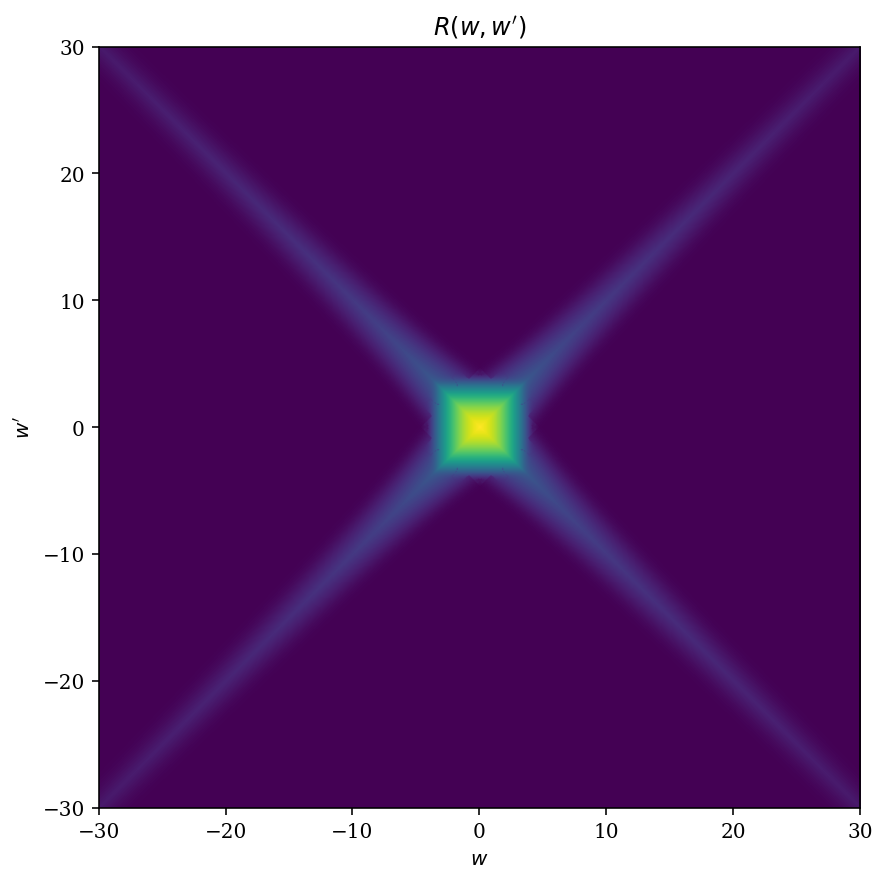

In [232]:
#What does it look like? 
# this is what Rwwp looks like at every given w, wp
fig = plt.figure(figsize=(7,7))
plt.imshow(np.log(Rwwp + 1.0e-9), extent = [w_min, w_max, wp_min, wp_max], origin = "lower")
plt.gca().set_aspect(w_max/wp_max)
plt.xlabel(r"$w$")
plt.ylabel(r"$w'$")
plt.title("$R(w,w')$")

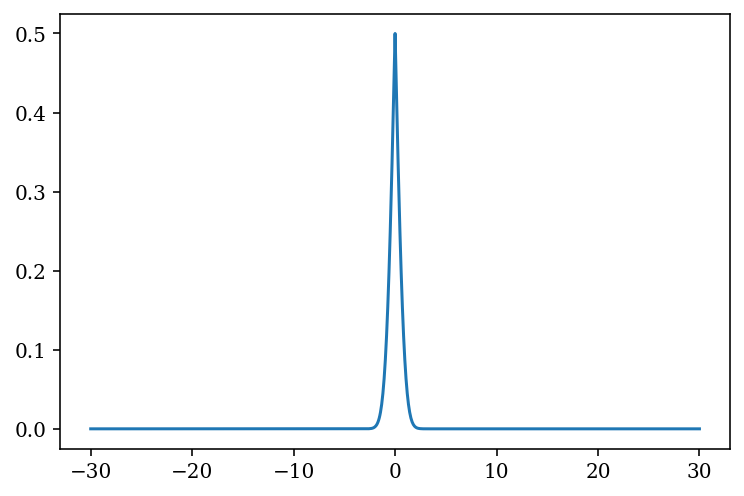

In [233]:
plt.plot(wp, Rwwp[500,:])

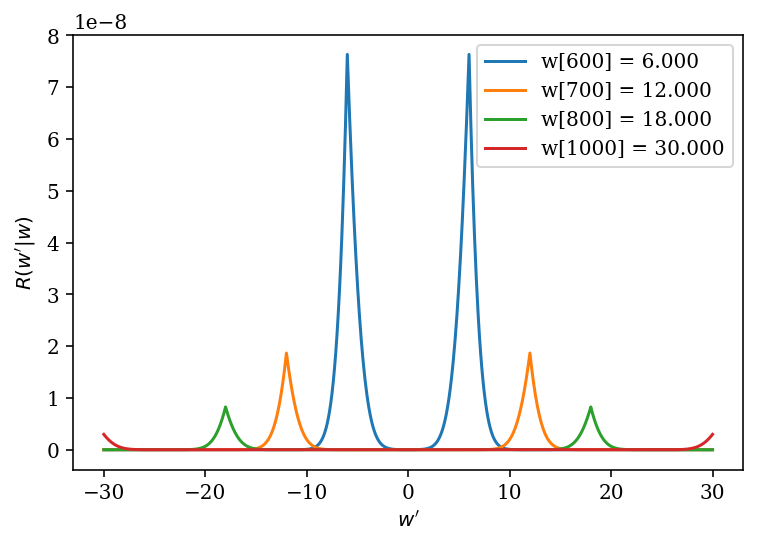

In [234]:
# plot values of R(w,w') at various columns of wp

c = 100
i = 6*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rwwp[:,i], label = s)

i = 7*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rwwp[:,i], label = s)

i = 8*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rwwp[:,i], label = s)

i = 10*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rwwp[:,i], label = s)

plt.ylabel(r"$R(w'|w)$")
plt.xlabel(r"$w'$")

plt.legend()

In [235]:
Rint = np.zeros_like(Rwwp) #same shape but filled with zeros

for i in range(n_w): 
    for j in range(1,n_wp): 
        # trapezoidal rule
        Rint[j,i] = 0.5*(Rwwp[j-1, i] + Rwwp[j, i]) * (wp[j] - wp[j-1]) + Rint[j-1, i]

In [236]:
# normalize, divide by last value in row...
Rint_norm = np.zeros_like(Rint) #same shape but filled with zeros

for i in range(n_wp):
    for j in range(n_wp):
        Rint_norm[j,i] = Rint[j,i] / Rint[-1, i]

Text(0.5, 1.0, "Normalized $\\int R(w,w')$")

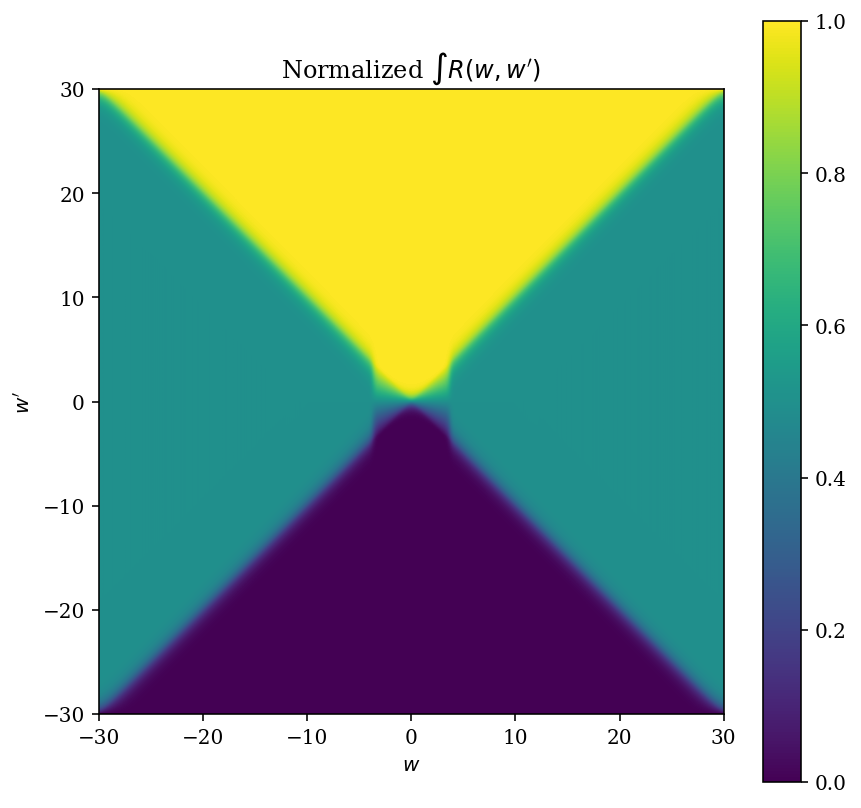

In [237]:
#What does it look like? 
fig = plt.figure(figsize=(7,7))
plt.imshow(Rint_norm, extent = [w_min, w_max, wp_min, wp_max], origin = "lower")
plt.gca().set_aspect(w_max/wp_max)
plt.xlabel(r"$w$")
plt.ylabel(r"$w'$")
plt.colorbar()
plt.title("Normalized $\int R(w,w')$")

# this is a tabulation of the cdf at every point of w, w', ie Rint! 

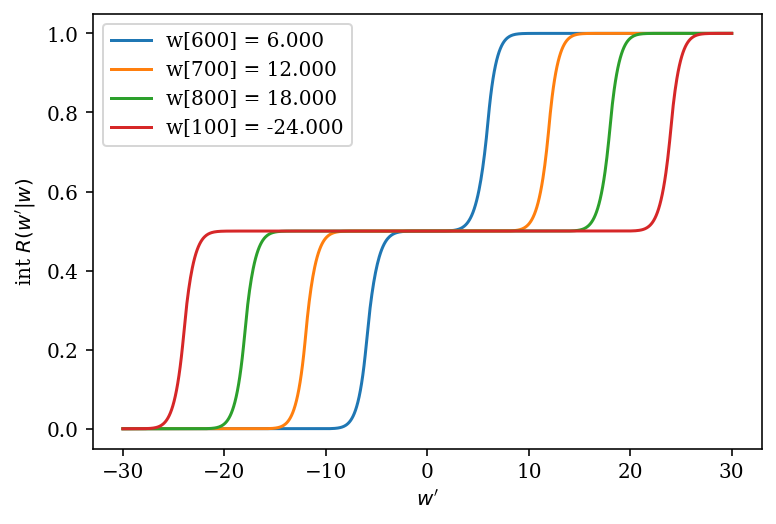

In [238]:
# plot values of R(w,w') at various columns of wp
i = 6*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rint_norm[:,i], label = s)

i = 7*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rint_norm[:,i], label = s)

i = 8*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rint_norm[:,i], label = s)

i = 1*c
s = "w[%d] = %4.3f" % (i, w[i])
plt.plot(wp, Rint_norm[:,i], label = s)

plt.ylabel(r"int $R(w'|w)$")
plt.xlabel(r"$w'$")

plt.legend()

In [239]:
# the purpose of this is to basically return wpc based on interpolation... 
def w_random(wc, xi_w): 
    
    # find the w index bounding current w 
    w_index = np.searchsorted(w, wc, side = "left") # real w not random
    #print("w_index %g " % w_index)
    
    #define i, i+1 
    i = w_index - 1 # lower value of w_index
    i_plus_1 = w_index 
    
    #find the wp indices bounding xi_p
    wp_index = np.searchsorted(Rint_norm[:,i], xi_w)
    #print("wp_index %g " % wp_index)
    #print("value at wp_index:")
    #print(Rint_norm[wp_index, i])
    
    wp_index_plus_1 = np.searchsorted(Rint_norm[:,i_plus_1], xi_w)
    #print("wp_index_plus_1 %g " % wp_index_plus_1)
    #print("value at wp_index_plus_1:")
    #print(Rint_norm[wp_index_plus_1, i])

    # define j, j+1 
    j = wp_index-1
    j_plus_1 = wp_index_plus_1-1 
    
    #assure the bounding box is large enough
    if(j>ja): 
        j_plus_1 = j
    elif(j<ja): 
        j = j_plus_1
        
    jp1 = j+1
    
    #define t, z0, z1, z2, z3, and z,
    t = (wc-w[i])/(w[i_plus_1]-w[i])
    #print("t %g" %t)
    
    z0 = Rint_norm[j,i]
    z1 = Rint_norm[jp1, i]
    z2 = Rint_norm[j, i_plus_1]
    z3 = Rint_norm[jp1, i_plus_1]
    
    #find u
    u = (xi_w - z2*t - z0*(1.-t))/((z1-z0)*(1.-t) + (z3-z2)*t)
    #print(len(u))
    
    #get wp
    wpc = u*(wp[jp1] -wp[j]) + wp[j]
    #print(wpc)
    return wpc 

def H_0(w): 
    if np.abs(w) < 2: 
        w = 1.0e-6
        H_0 = np.exp(-w**2)
    else: 
        H_0 = np.exp(-w**2)
    return H_0

def H_w_a(w): 
    a = 4.7e-4 * np.sqrt(10/10**4)
    if np.abs(w) < 2: 
        w = 1.0e-6
        K_w = (1/ (2*w**2) ) * ( H_0(w)*(4*w**2 + 3)*((w**2)+1) - w**(-2)*((2*w**2)+3)*np.sinh(w**2))
        parentheses = (1-(2*a/np.sqrt(np.pi))*K_w)
    else: 
        K_w = (1/ (2*w**2) ) * ( H_0(w)*(4*w**2 + 3)*((w**2)+1) - w**(-2)*((2*w**2)+3)*np.sinh(w**2))
        parentheses = (1-(2*a/np.sqrt(np.pi))*K_w)
    return H_0(w)*parentheses
    
def tau_H(w, tau_0): 
    numerator = H_w_a(w)
    denominator = H_w_a(0)
    return tau_0*numerator/denominator

In [240]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [247]:
# initial conditions
tau_0 = 10**4 # half-thickness optical depth 
x_0 = 1.0 # half-thickness in arb units 
alpha_0 = tau_0 / x_0 # absorption coefficient
w_final = [] # list to store final w
# we want this to occur for 1000 photons

n_photons = 1000

for i in range(n_photons): 
    # initialize our position
    x_prev = 0.0
    y_prev = 0.0
    z_prev = 0.0

    x_traj = []
    y_traj = []
    z_traj = []

    # initialize our frequency
    w_prev = 0

    w_traj = []

    flag = True

    x_traj.append(x_prev)
    y_traj.append(y_prev)
    z_traj.append(z_prev)

    i = 0 
    
    wc = w_prev

    while(flag): 

        # pull a random dirction and distance
        xi_phi = rng.uniform(0., 1.) # xi_phi
        xi_theta = rng.uniform(0., 1.) # xi_theta
        xi_tau = rng.uniform(0., 1.) # xi_tau

        # convert to phi, theta, and tau
        phi = phi_random(xi_phi)
        theta = theta_random(xi_theta)
        tau = tau_random(xi_tau) # this is tau_int 

        # find physical distance traveled
        if i == 0: 
            l = tau/alpha_0 
        else: 
            alpha_0 = tau/x_0
            l = tau/alpha_0
            
        # find new location, projected into cartesian
        x_new = x_prev + l*np.sin(theta)*np.cos(phi)
        y_new = y_prev + l*np.sin(theta)*np.sin(phi)
        z_new = z_prev + l*np.cos(theta)

        # update the trajectory
        x_traj.append(x_new)
        y_traj.append(y_new)
        z_traj.append(z_new)

        # update properties
        x_prev = x_new
        y_prev = y_new
        z_prev = z_new
        
        # pull a random frequency
        xi_w = rng.uniform(0, 1)
        #print("xi_w %g" % xi_w)
        
        wc = w_random(wc, xi_w) # returns wpc, which is now wc
        #print("wc %G" % wc)
        w_traj.append(wc) 

        i+=1
        # optical depth at new frequency will be lower 
        # create a function that returns the optical depth at
        # new frequency... 
        tau_H_medium = tau_H(wc, tau_0)
        
        if(tau > tau_H_medium):
            w_final.append(w_traj[i-1]) 
            flag = False # not sure if this is correct

In [292]:
a = 4.7e-4 * np.sqrt(10/10**4)
l_bound = -50
u_bound = 50
J_func = lambda x: (np.sqrt(6)*x**2)/(24*np.sqrt(np.pi)*a*tau_0)*(np.cosh((np.pi**3*np.abs(x**3))/(54*a*tau_0)))**-1
J_int = integrate.quad(J_func, l_bound, u_bound)[0]

/home/diana/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.


Text(0.5, 0, '$w$')

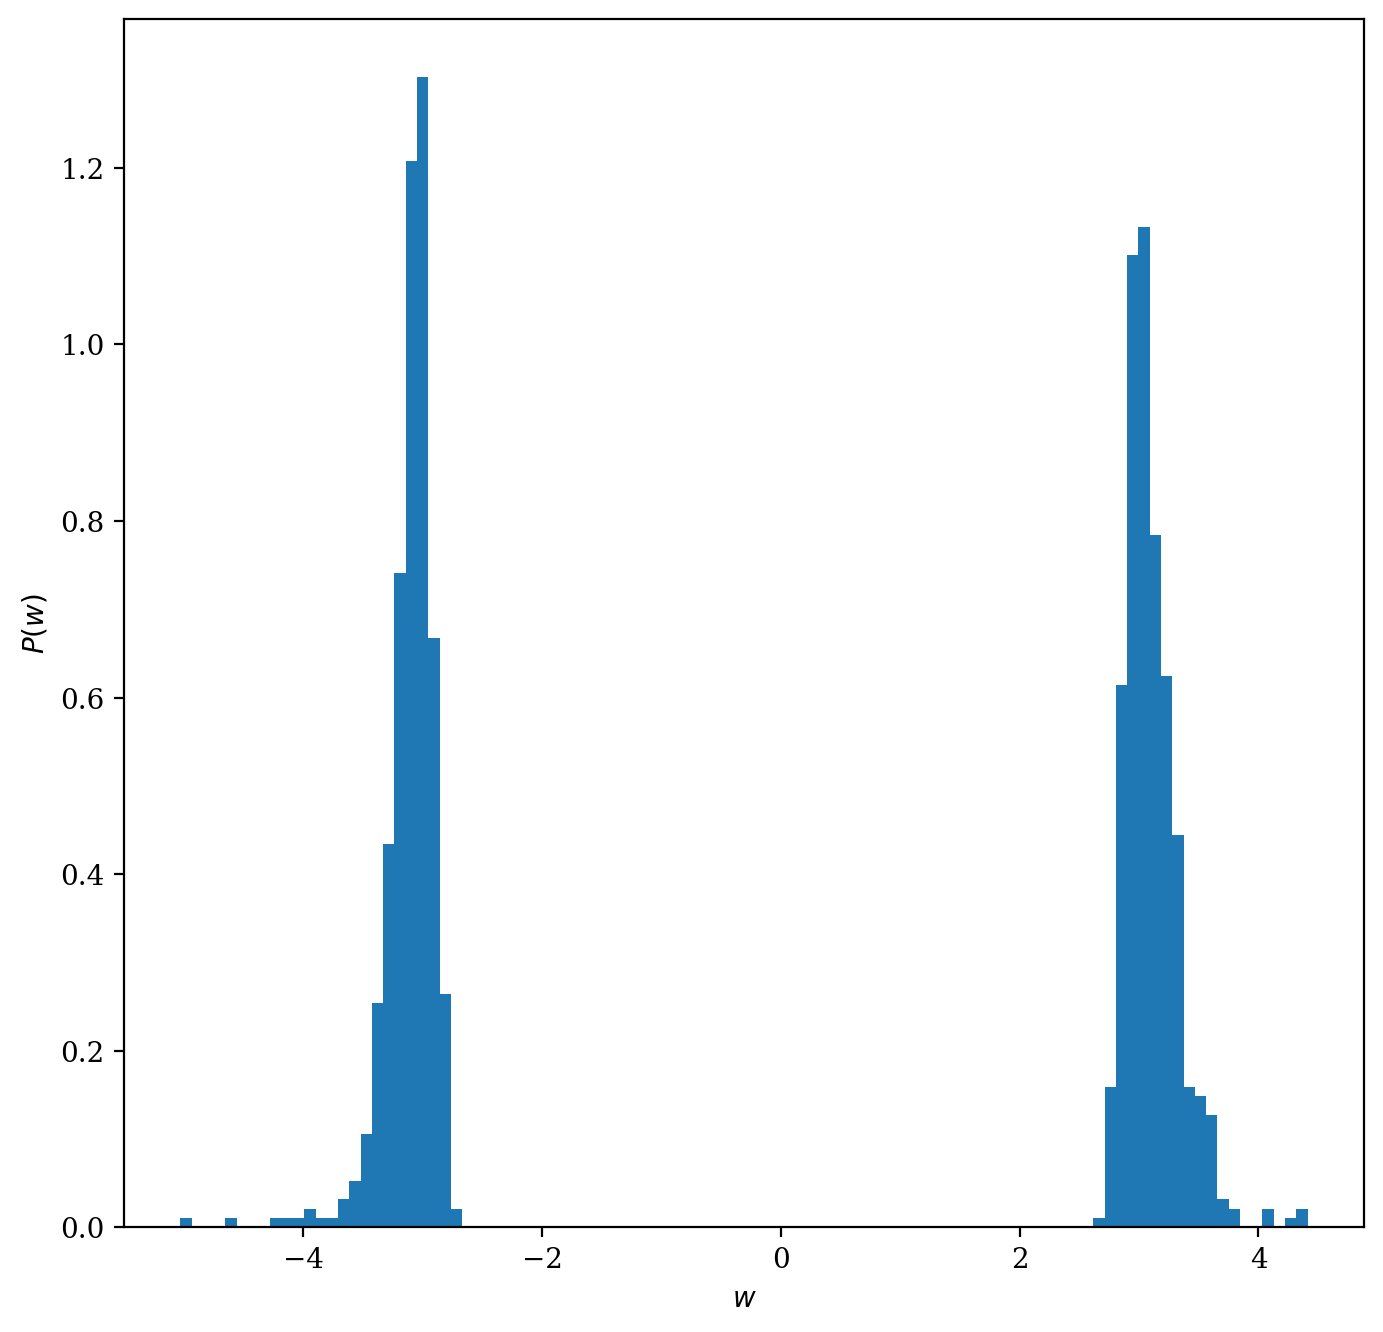

In [296]:
fig, ax = plt.subplots(figsize=(8,8),dpi=100) # make figure larger
n, bins, patches = plt.hist(w_final, bins = 100, density = True);

"""
x = np.linspace(-10, 10, nbins)
P = []
for i in range(len(x)): 
    J = (np.sqrt(6)*x[i]**2)/(24*np.sqrt(np.pi)*a*tau_0)*(np.cosh((np.pi**3*np.abs(x[i]**3))/(54*a*tau_0)))**-1
    P.append(J/J_int)
plt.plot(x, P)
"""
plt.ylabel(r"$P(w)$")
plt.xlabel(r"$w$")

Interestingly, the distribution of frequencies at which the photon escapes the cloud after interacting with Hydrogen atoms does not peak at the expected locations given in the solution. 

In [250]:
import csv

In [253]:
with open('FINAL_PROJECT_data', 'w') as f:
    write = csv.writer(f)
    writer = write.writerow(w_final)